 -----------------------------------------------------------
# Reestimating Cogley and Sargent (2005) with the updated sample

* **Author:** Balint Szoke
* **Last update:** June, 2016

> Using the **updated sample** with the **priors of Cogley and Sargent (2005)** this notebook reestimates the stochastic volatility model (with time-varying coefficients) with `pymc` 

>> It requires `cogleysargent.py` which contains the following step methods:
 - `ForwardBackward`: $\hspace{6mm}\theta^T \hspace{2mm}\mid\hspace{2mm} Y^T, Q, R^T$
 - `W_Q`: $\hspace{30mm} Q^{-1}\hspace{2mm}\mid\hspace{2mm} Y^T, \theta^T$
 - `Metropolis_LH`: $\hspace{9mm} H^T \hspace{2mm}\mid\hspace{2mm} Y^T, \theta^T, \beta, \sigma$
 - `N_Beta`: $\hspace{28mm}\beta \hspace{2mm}\mid\hspace{2mm} Y^T, \theta^T, H^T$
 - `IG_Sigma`: $\hspace{22mm}\sigma^2 \hspace{2mm}\mid\hspace{2mm} Y^T, H^T$

>> and `cogleysargent_utils.py` 
 - `Genearate_prior` : class to estimate a SUR model on the training set in order to provide informative priors
 - `cs_model` : a function that creates a pymc model (see also the "replication notebook")
 
 -----------------------------------------------------------


### Model

We consider the following state-space model:

\begin{align}
y_t &= X_t\theta_t + \varepsilon_t \hspace{2cm}\text{where}\hspace{5mm} \varepsilon_t \sim \mathcal{N}(0,R_t) \\
\theta_{t} &= \theta_{t-1} + v_t \hspace{22mm}\text{where}\hspace{5mm} v_t \sim \mathcal{N}(0,Q) \\
\log(h_t) & = \log(h_{t-1}) + \eta_t \hspace{12mm}\text{where}\hspace{5mm} \eta_t \sim \mathcal{N}(0,\text{diag}(\sigma))
\end{align}

where $y_t$ is a vector of endogenous variables, $X_t$ includes constant plus lags of $y_t$ and $\theta_t$ is a vector of VAR parameters. The first equation is the measurement equation; the second is the state equation modeling the VAR coefficients as driftless random walks subject to reflecting barriers. The reflecting barrier is encoded in an indicator function $I(\theta^T)=\prod_{t=1}^T I(\theta_t)$, where $I(\theta_t)$ takes the value $1$ when $\theta_t$ implies roots of the associated VAR polynomial outside the unit circle and $0$ otherwise. This restriction truncates and renormalizes the random walk prior. 

$h_t$ is a vector of independent stochastic volatilities (same size as $y_t$) and 

\begin{align}
R_t = B^{-1}\text{diag}(h_t)(B^{-1})^T
\end{align}

**Notations:**
- $y_t$ and $\varepsilon_t$ are $K\times 1$-vectors for all $t=1,\dots,T$
- $x_t$ contains a constant plus $L$ lags of the endogenous variables, i.e. $x_t = [1, y_{t-1}^T, y_{t-2}^T, \dots, y_{t-L}^T]^T$ is an $M\times 1$ vector, where $M \equiv 1+LK$ and $X_t = I_K \otimes x^T_t$ is a $K\times KM$ matrix 
- $\theta_t$ and $v_t$ are $KM\times 1$ vectors
- $h_t$, $\eta_t$ and $\sigma$ are $K\times 1$-vectors, where $\sigma = [\sigma_1,\dots,\sigma_K]^T$
- $B$ is a $K\times K$ matrix 

$$B = \left[\begin{matrix} 1 & 0 & \dots & 0 \\ \beta_{2,1} & 1 & \dots & 0 \\  \dots & \dots & \dots & \dots \\ \beta_{K,1} & \beta_{K,2} & \dots & 1\end{matrix}\right] $$
- $J=\frac{K(K-1)}{2}$ is the total number of $\beta_{ij}$ included in $B$, i.e. $\beta=[\beta_{21}, \dots,\beta_{K(K-1)}]^T$ is a $J\times 1$ vector


### Priors

We assume that initial state $\theta_0$ and the hyperparameters are independent across blocks

$$f(\theta_0, h_0, Q^{-1}, \beta, \sigma) = f(\theta_0) f(h_0) f(Q^{-1}) f(\beta) f(\sigma) $$

and our priors are

- $\theta_0 \propto I(\theta_0)\mathcal{N}(\bar{\theta},\bar{P})$
- $Q^{-1} \sim \mathcal{W}(KM+1, \bar{Q})$ 
- $\sigma_i \sim \mathcal{IG}(\alpha_{i0},\beta_{i0})$ for $i=1,\dots, K$
- $h_{0,i} \sim \log\mathcal{N}(\bar{h}_i,\bar{P}_{h,i})$ for $i=1,\dots,K$
- $\beta \sim \mathcal{N}(\bar{\beta}, \bar{P}_{\beta})$

Notice that these along with the state equations already provide us with priors for $\theta^T$ and $h^T$.

### Defining the model in `pymc`

Therefore, we need to come up with values for the following parameters to define a pymc model:

$$\bar{\theta},\bar{P},\bar{Q},\bar{\beta},\bar{P}_{\beta},\{\alpha_{i0}\}_{i},\{\beta_{i0}\}_{i},\{\bar{h}_i\}_{i},\{\bar{P}_{h,i}\}_{i}$$

Given these parameters and the data we should be able to draw from the posterior distribution of any model of the above form. 

-------------------------------------------------------_

In [1]:
%matplotlib inline

# Standard packages:
import numpy as np
import scipy as sp
from scipy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sb

# pymc and application specific packages
import pymc as pm
from cogleysargent import *
from cogleysargent_utils import *

### Load the updated sample and create the dataset passed to the prior generator

   *Sample period:* from 1948:Q2 to 2016:Q2
   
   *Variables:*
   - **dp** : CPI for all urban consumers (seasonally adj), log diff between the third month of each quarter
   - **y3** : yield on 3-month Treasury Bill, average of daily rates in the first month of each quarter
   - **ur** : civilian unemployment rate (seasonally adj), quarterly average of monthly rates
       =>  **ur2** : logit of unemployment

In [2]:
data = pd.read_csv('../data/updated_sample.csv', index_col = 0)

# dependent variables of the VAR
y3 = np.expand_dims(data['y3'], 1)    # yield on 3-month Treasury bills
dp = np.expand_dims(data['dp'], 1)    # CPI for all urban consumers (seasonally-adj)
ur = np.expand_dims(data['ur'], 1)    # civilian unemployment rate (seasonally-adj)
ur2 = .01 * np.log(ur / (1 - ur))     # logit of unemployment

y = np.hstack((y3, ur2, dp))

Estimate the training sample to get priors

In [3]:
training = Generate_prior(y)

In [4]:
X, Y_obs, X_obs = training.create_YX()[3:]
theta_bar, b_bar, Pb_bar, a0, b0, lnh_bar, Ph_bar, P_bar, Q_bar = training.informative_prior()

In [5]:
mcmc, Theta, LH, Q_inv, Sigma2, Betas, R = \
                cs_model(Y_obs, X_obs, X, theta_bar, b_bar, Pb_bar, a0, b0, lnh_bar, Ph_bar, P_bar, Q_bar, 
                         'pymc_sample_updated.pickle')

In [6]:
NI = 100000
NB = 50000
NT = 10
mcmc.sample(iter = NI, burn = NB, thin = NT)

sample_size = int((NI - NB)/NT)
mcmc.db.close()

 [-----------------100%-----------------] 100000 of 100000 complete in 6695.3 sec

In [7]:
T = Y_obs.shape[0]
K = Y_obs.shape[1]
M = X_obs.shape[1]
KM = theta_bar.size
J = int(K*(K-1)/2)

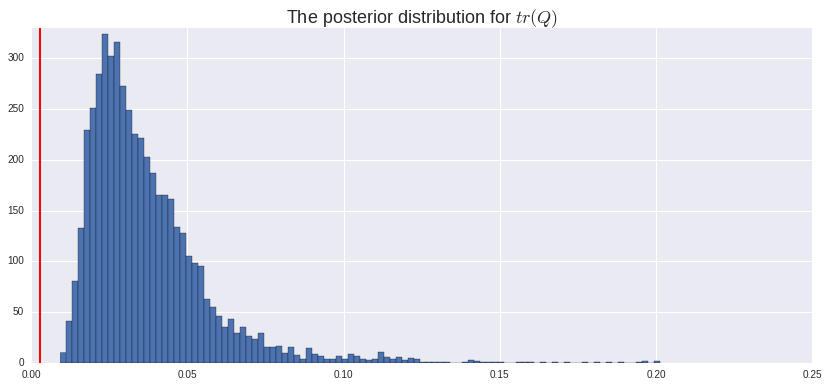

In [9]:
fig1, ax = plt.subplots(figsize = (14, 6), sharex = True, sharey = True)
ax.hist([np.trace(inv(mcmc.trace('Q_inv')[:][i])) for i in range(sample_size)], bins = 100)
ax.vlines(np.trace(Q_bar/(1 + KM)), 0, 330, color = 'r', lw = 2)
ax.set_title(r'The posterior distribution for $tr(Q)$', fontsize = 18)
ax.axis([0, .25, 0, 330])

plt.savefig('../figures/fig1_updated.pdf')

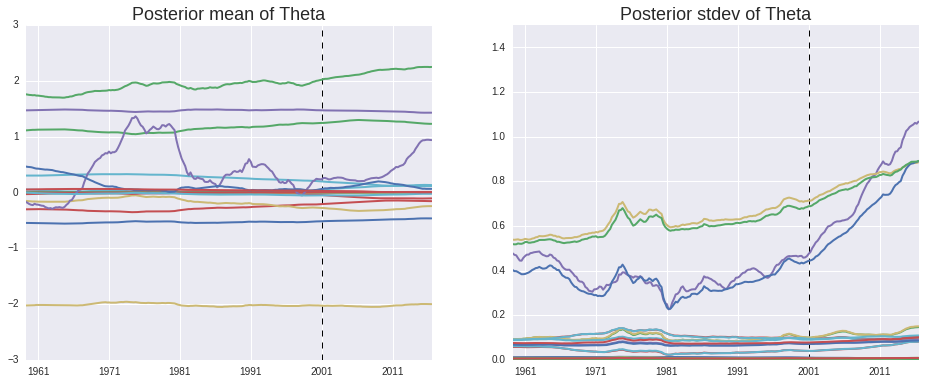

In [23]:
date_axis = np.asarray(pd.date_range('1959-01-01', '2016-06-30', freq = 'Q'))

post_mean_theta = np.empty((KM, T))
post_std_theta = np.empty((KM, T))

for j in range(KM):
    post_mean_theta[j, :] = [np.mean(mcmc.trace('Theta_%d' % i)[:][:, j]) for i in np.arange(1, T + 1)]
    post_std_theta[j, :] = [np.std(mcmc.trace('Theta_%d' % i)[:][:, j]) for i in np.arange(1, T + 1)]

fig2, ax = plt.subplots(1, 2, figsize = (16, 6), sharex = True)
ax[0].plot(date_axis, post_mean_theta.T, linewidth = 2)
ax[0].set_title(r'Posterior mean of Theta', fontsize = 18)
ax[0].vlines('2000-12-31', -3, 3, color = 'k', lw = 1, linestyle = '--')
ax[0].set_ylim([-3, 3])
ax[1].plot(date_axis, post_std_theta.T, linewidth = 2)
ax[1].set_title(r'Posterior stdev of Theta', fontsize = 18)
ax[1].set_ylim([0, 1.5])
ax[1].vlines('2000-12-31', 0, 1.5, color = 'k', lw = 1, linestyle = '--')

plt.savefig('../figures/fig2_updated.pdf')

In [15]:
R_sample = np.empty((sample_size, T + 1, K, K))

for i in range(sample_size):
    
    Binv = inv(B_tril(mcmc.trace('betas')[:][i, :]))
    
    for tt in range(T + 1):
        H_matrix = np.diag(np.exp(mcmc.trace('lnh_%d' % tt)[:][i, :]))        
        R = Binv  @ H_matrix @ Binv.T
        R_sample[i, tt, :, :] = R

R_mean = np.mean(R_sample, 0)

nomint = np.sqrt(R_mean[:, 0, 0])
unemp = np.sqrt(R_mean[:, 1, 1])
inflation = np.sqrt(R_mean[:, 2, 2])

corr_nu = R_mean[:, 0, 1]/(nomint * unemp)
corr_ni = R_mean[:, 0, 2]/(nomint * inflation)
corr_iu = R_mean[:, 1, 2]/(unemp * inflation)

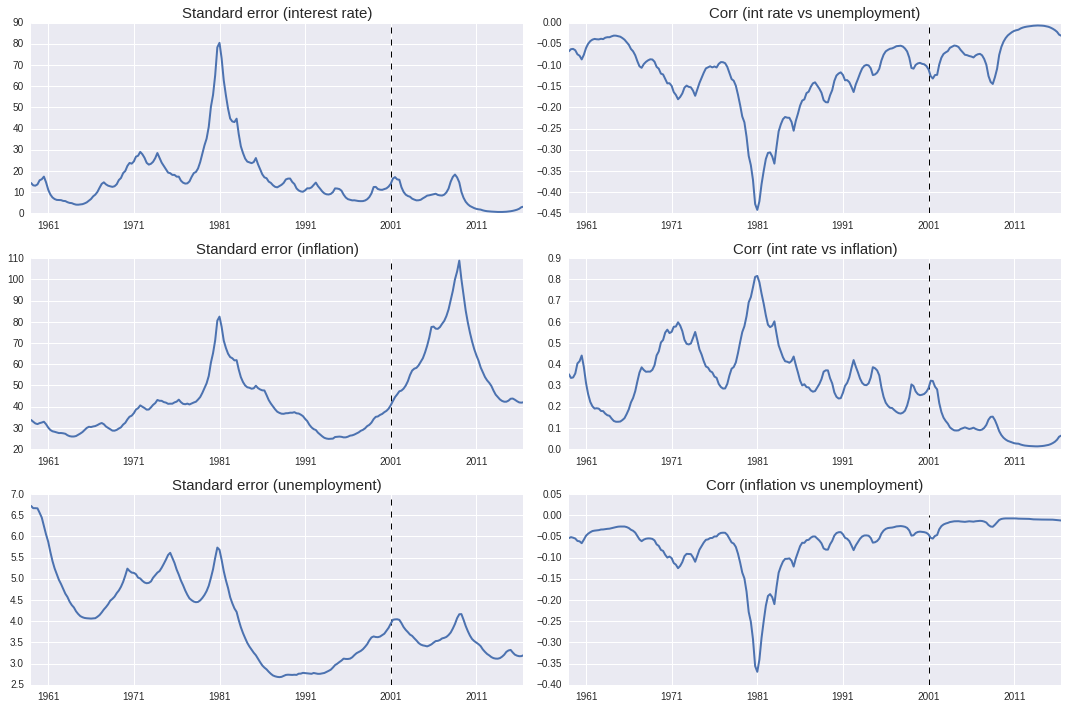

In [27]:
date_axis = np.asarray(pd.date_range('1958-12-01', '2016-06-30', freq = 'Q'))

fig3, ax = plt.subplots(3, 2, figsize = (15, 10))
ax[0, 0].plot(date_axis, 1e4*nomint, linewidth = 2, label = 'pymc')
ax[0, 0].set_title(r'Standard error (interest rate)', fontsize = 15)
ax[0, 0].vlines('2000-12-31', 0, 90, color = 'k', lw = 1, linestyle = '--')

ax[1, 0].plot(date_axis, 1e4*inflation, linewidth = 2)
ax[1, 0].set_title(r'Standard error (inflation)', fontsize = 15)
ax[1, 0].vlines('2000-12-31', 20, 110, color = 'k', lw = 1, linestyle = '--')

ax[2, 0].plot(date_axis, 1e4*unemp, linewidth = 2)
ax[2, 0].set_title(r'Standard error (unemployment)', fontsize = 15)
ax[2, 0].vlines('2000-12-31', 2.5, 7, color = 'k', lw = 1, linestyle = '--')

ax[0, 1].plot(date_axis, corr_nu, linewidth = 2)
ax[0, 1].set_title(r'Corr (int rate vs unemployment)', fontsize = 15)
ax[0, 1].vlines('2000-12-31', -0.45, 0, color = 'k', lw = 1, linestyle = '--')

ax[1, 1].plot(date_axis, corr_ni, linewidth = 2)
ax[1, 1].set_title(r'Corr (int rate vs inflation)', fontsize = 15)
ax[1, 1].vlines('2000-12-31', 0, .9, color = 'k', lw = 1, linestyle = '--')

ax[2, 1].plot(date_axis, corr_iu, linewidth = 2)
ax[2, 1].set_title(r'Corr (inflation vs unemployment)', fontsize = 15)
ax[2, 1].vlines('2000-12-31', -0.4, 0, color = 'k', lw = 1, linestyle = '--')
plt.tight_layout()

plt.savefig('../figures/fig3_updated.pdf')

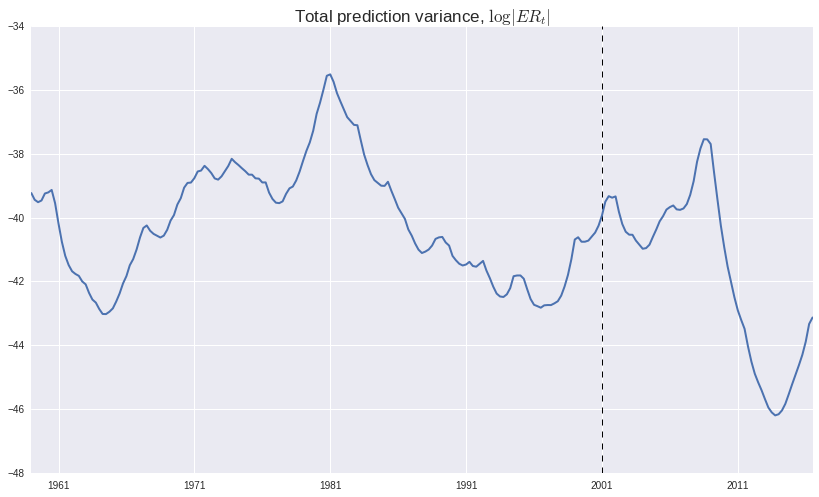

In [28]:
logdetR = np.empty((T + 1, 1))

for tt in range(T + 1):
    logdetR[tt, 0] = np.log(np.linalg.det(R_mean[tt, :, :]))

fig3, ax = plt.subplots(figsize = (14, 8))
ax.plot(date_axis, logdetR, linewidth = 2, label = 'pymc')
ax.set_title(r'Total prediction variance, $\log |E R_t|$', fontsize = 17)
ax.vlines('2000-12-31', -48, -34, color = 'k', lw = 1, linestyle = '--')

plt.savefig('../figures/fig4_updated.pdf')